# Object Detection Module 

In [2]:
label_map = {
    1: "top", 
    2: "bottom", 
    3: "dress"
}

In [3]:
from detector import DetectorTF2 

detector = DetectorTF2(
    "../trained_model/frozen_model_1/saved_model/", 
    labelmap= label_map,
    threshold=0.50
)

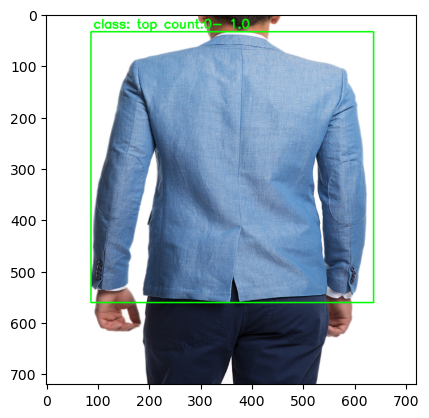

In [4]:
import matplotlib.pyplot as plt 
import cv2 

img = cv2.imread("../data/IMG_all/train/CEKET/6.png")

det_boxes = detector.DetectFromImage(img)
detected_img = detector.DisplayDetections(img, det_boxes) 

plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGBA))
plt.show() 

In [5]:
detected_img.shape 

(720, 720, 3)

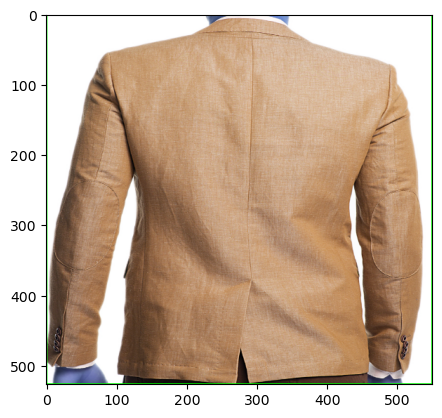

In [6]:
cropped_img = detected_img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] 
plt.imshow(cropped_img)
plt.show() 

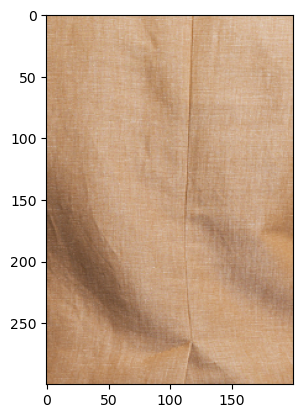

In [7]:
cw = 200 
ch = 300
center = cropped_img.shape
x = center[1]/2 - cw/2
y = center[0]/2 - ch/2
center_cropped = cropped_img[int(y):int(y+ch), int(x):int(x+cw)] 
plt.imshow(center_cropped) 
plt.show() 

# Color-Thief 

In [8]:
from colorthief import ColorThief 

def crop_image(img_path:str, detector: DetectorTF2, sample_wh = (200, 200)): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    
    cw = sample_wh[0] 
    ch = sample_wh[1] 
    center = img.shape
    x = center[1]/2 - cw/2
    y = center[0]/2 - ch/2
    img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

In [9]:
def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w, _ = [ zoom * i for i in img.shape ]
    
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize(img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
               : ]
    
    return img

In [10]:
import io 

def get_dominant_from_image(img_path:str, detector: DetectorTF2,zoom_rate ,sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    byteImgIO = io.BytesIO()
    byteImg = Image.fromarray(img)
    byteImg.save(byteImgIO, "PNG")
    byteImgIO.seek(0)
    byteImg = byteImgIO.read() 
    dataBytesIO = io.BytesIO(byteImg)
    ct = ColorThief(dataBytesIO) 
    
    dominant_color = ct.get_color(quality=1) 
    palette = ct.get_palette(color_count=n_palette, quality=1)  

    return img, detected_img, dominant_color, palette

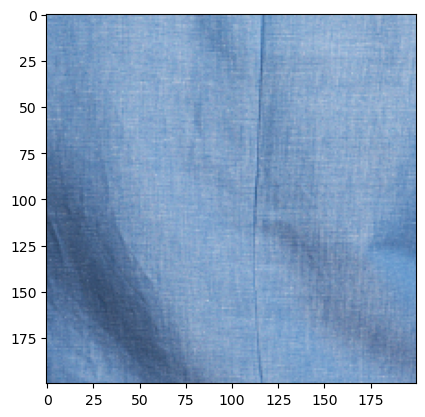

In [11]:
plt.imshow(crop_image("../data/IMG_all/train/CEKET/6.png", detector)) 
plt.show() 

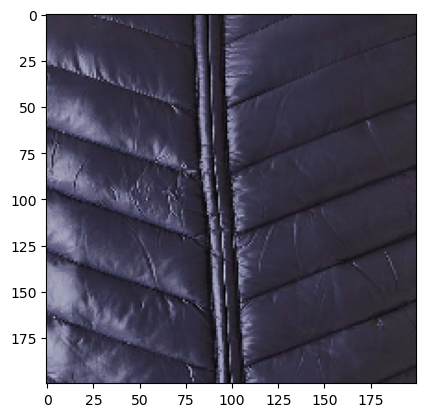

In [12]:
plt.imshow(crop_image("../data/IMG_all/train/dis-giyim/9.png", detector, sample_wh=(200, 200))) 
plt.show() 

In [13]:
path = "../data/IMG_all/demo/manolya_kadin.png"
cropped_img, detected_img, dom_color, palette = get_dominant_from_image(path, detector=detector, zoom_rate=2, sample_wh=(100, 200), n_palette=2)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = 100
cv = cv2.rectangle(image, (100,y_point), (200,y_point + 100), dom_color, -1)  
for c in palette: 
    y_point += 100 
    cv = cv2.rectangle(image, (100, y_point), (200, y_point + 100), c, -1) 

plt.imshow(cv)
plt.show() 
plt.imshow(cropped_img)
plt.show() 
plt.imshow(detected_img)
plt.show()  

NameError: name 'Image' is not defined

In [14]:
import cv2
import numpy as np


def create_bar(height, width, color):
    bar = np.zeros((height, width, 3), np.uint8)
    bar[:] = color
    red, green, blue = int(color[2]), int(color[1]), int(color[0])
    return bar, (red, green, blue)

img = cv2.imread('../data/IMG_all/demo/kiz_cocuk.png')
height, width, _ = np.shape(img)
# print(height, width)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)

number_clusters = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)
# print(centers)

font = cv2.FONT_HERSHEY_SIMPLEX
bars = []
rgb_values = []

for index, row in enumerate(centers):
    bar, rgb = create_bar(200, 200, row)
    bars.append(bar)
    rgb_values.append(rgb)

img_bar = np.hstack(bars)

for index, row in enumerate(rgb_values):
    image = cv2.putText(img_bar, f'{index + 1}. RGB: {row}', (5 + 200 * index, 200 - 10),
                        font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    print(f'{index + 1}. RGB{row}')

cv2.imshow('Image', img)
cv2.imshow('Dominant colors', img_bar)
# cv2.imwrite('output/bar.jpg', img_bar)

# cv2.waitKey(0)

1. RGB(255, 255, 255)
2. RGB(247, 176, 174)
3. RGB(221, 146, 145)
4. RGB(245, 234, 221)
5. RGB(11, 11, 21)


In [15]:
def get_dominant_from_image(img_path:str, detector: DetectorTF2, zoom_rate , sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, n_palette, None, criteria, 10, flags)
    
    return img, detected_img, centers.astype(np.int16) 

In [16]:
img, detected_img, centers  = get_dominant_from_image("../data/IMG_all/demo/kiz_cocuk.png", detector, 2)

In [17]:
for c in centers: 
    print(tuple(c))

(246, 236, 224)
(238, 165, 162)
(14, 13, 23)


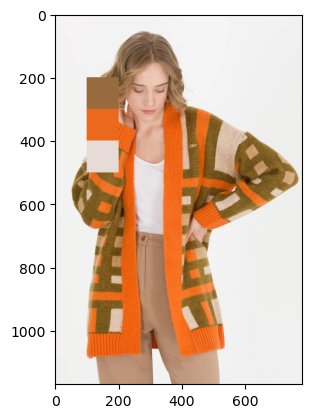

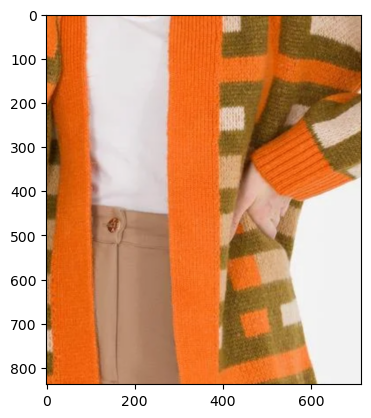

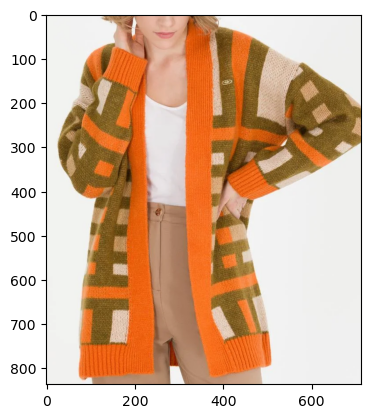

In [64]:
path = "../data/IMG_all/train/sweat/asdasdasd.webp"
img, detected_img, centers = get_dominant_from_image(path, detector=detector, zoom_rate=2, sample_wh=(100, 200), n_palette=3)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = 100
for c in centers: 
    y_point += 100 
    cv = cv2.rectangle(image, (100, y_point), (200, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 

plt.imshow(cv)
plt.show() 
plt.imshow(img)
plt.show() 
plt.imshow(detected_img)
plt.show() 